## Pour utiliser PySpark dans le notebook et ne pas avoir besoin de toucher au fichier de configuration du bash

findspark installé avec pip : pip install findspark

Et mettre le bon chemin vers $SPARK_HOME dans findspark.init()

In [1]:
import findspark
findspark.init("/opt/spark-2.3.2-bin-hadoop2.7")

# Projet Big Data

Challenge Kaggle sur https://www.kaggle.com/c/criteo-display-ad-challenge en utilisant PySpark

## Chargement des données

In [2]:
from pyspark import SparkContext
from pyspark import SQLContext

sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
dataset = sc.textFile("dac/small_train.txt")

## Pré-traitement des données

Charger les données récupérées dans des dataframes ayant des noms de colonne, puis faire un cast des colonnes contenant des entiers pour qu'ils aient bien un type Integer

In [4]:
dataset = dataset.map(lambda x : x.split("\t"))

In [5]:
columns = ["label"]
columns += ["integer_feature_{}".format(i) for i in range(1,14)]
columns += ["categorical_feature_{}".format(i) for i in range(1,27)]
df = sqlContext.createDataFrame(dataset,columns)

In [6]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
for colname in ["label"] + ["integer_feature_{}".format(j) for j in range(1,14)]:
    df = df.withColumn(colname, col(colname).cast(IntegerType()))

In [7]:
df.printSchema()
print(df.take(2))

root
 |-- label: integer (nullable = true)
 |-- integer_feature_1: integer (nullable = true)
 |-- integer_feature_2: integer (nullable = true)
 |-- integer_feature_3: integer (nullable = true)
 |-- integer_feature_4: integer (nullable = true)
 |-- integer_feature_5: integer (nullable = true)
 |-- integer_feature_6: integer (nullable = true)
 |-- integer_feature_7: integer (nullable = true)
 |-- integer_feature_8: integer (nullable = true)
 |-- integer_feature_9: integer (nullable = true)
 |-- integer_feature_10: integer (nullable = true)
 |-- integer_feature_11: integer (nullable = true)
 |-- integer_feature_12: integer (nullable = true)
 |-- integer_feature_13: integer (nullable = true)
 |-- categorical_feature_1: string (nullable = true)
 |-- categorical_feature_2: string (nullable = true)
 |-- categorical_feature_3: string (nullable = true)
 |-- categorical_feature_4: string (nullable = true)
 |-- categorical_feature_5: string (nullable = true)
 |-- categorical_feature_6: string (nu

In [8]:
## Drop lines with null values in integer features
df = df.na.drop()

## Change null to na in categorical features
columns_toreplace = []
for i in range(1,27):
    columns_toreplace.append("categorical_feature_{}".format(i))
df = df.na.replace("", "na", columns_toreplace)

In [9]:
## Répartition des classes dans train
number_0 = df.filter(df.label == 0).count()
number_1 = df.filter(df.label != 0).count()
print(number_0)
print(number_1)

83121
35483


In [10]:
print("Class repartition :\n 0 : {} ({:2%}) \n 1 : {} ({:2%})"
      .format(number_0, number_0 / (number_0 + number_1), number_1, number_1 / (number_0 + number_1)))

Class repartition :
 0 : 83121 (70.082797%) 
 1 : 35483 (29.917203%)


# ML avec Spark

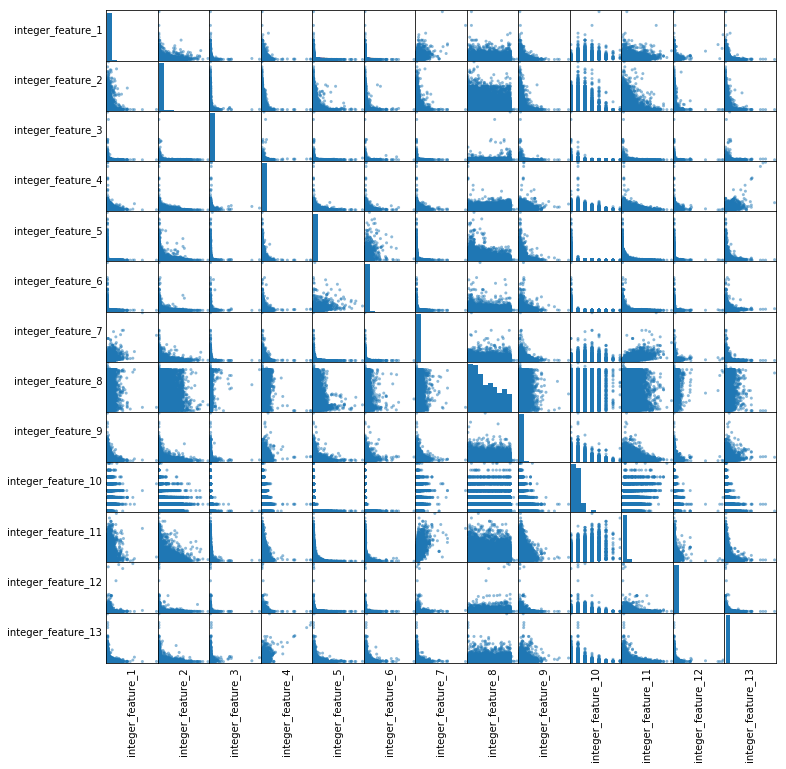

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


numeric_features = ["integer_feature_{}".format(i) for i in range(1,14)]

numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(12, 12));

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Corrélation de features ?

La 10eme feature d'entier semble avoir une corrélation avec toutes les autres features d'entier :

    - L'enlever
    
    - Ne garder qu'elle ?

# Pipeline ML

In [12]:
from pyspark.ml import Pipeline

## Stages pour la transformation des données

### String indexing + OneHotEncoding des categorical features pour les données

In [13]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

stages = []
categoricalColumns = ["categorical_feature_{}".format(i) for i in range(1,27)]

for categoricalCol in categoricalColumns:
    strIdx = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "_Idx")
    oneHot = OneHotEncoderEstimator(inputCols = [strIdx.getOutputCol()], outputCols = ["oneHot_" + categoricalCol])
#     print([strIdx.getOutputCol()])
#     print(["oneHot_" + categoricalCol])
    stages += [strIdx, oneHot]

### Assemblage des features gardées dans un vecteur de features

In [14]:
from pyspark.ml.feature import VectorAssembler

numericCols = ["integer_feature_{}".format(i) for i in range(1,14)]
assemblerInputs = ["oneHot_" + c for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [16]:
pipe = Pipeline().setStages(stages)
pipeModel = pipe.fit(df)
pp_df = pipeModel.transform(df)

In [17]:
#pp_df.printSchema()

In [58]:
select_cols = ["features"] + columns
pp_df = pp_df.select(select_cols)
train, test = pp_df.randomSplit([0.7, 0.3])
#train.printSchema()

# Train des modèles de ML

In [77]:
## Log loss de sklearn pour évaluer les modèles
from sklearn.metrics import log_loss

def logloss(y_true, y_proba):
    y_true = [y.__getitem__("label") for y in y_true]
    y_proba = [y.__getitem__("probability") for y in y_proba]
    y_proba = [[i for i in j] for j in y_proba]
    return log_loss(y_true, y_proba)

def accuracy(y_true, y_pred):
    y_true = [y.__getitem__("label") for y in y_true]
    y_pred = [y.__getitem__("prediction") for y in y_pred]
    egal = [y_true[i] == y_pred[i] for i in range(len(y_true))]
    return sum(egal)/len(y_true)

## Logistic Regression

In [88]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(maxIter=10, threshold=0.3)

# Train model with Training Data
lrModel = lr.fit(train)

#### Evaluation du modèle

In [89]:
predictions = lrModel.transform(test)

y_true = test.select("label").collect()
y_proba = predictions.select("probability").collect()
y_pred = predictions.select("prediction").collect()

In [90]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.6803792745346706

In [94]:
ll = logloss(y_true, y_proba)
acc = accuracy(y_true, y_pred)
print("Log loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}".format(ll / len(y_true), acc))

Log loss divisée par le nombre d'exemples = 0.000022,
Accuracy = 68.468266%


### Cross-validation

In [74]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [71]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [ ]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [ ]:
predictions = cvModel.transform(test)
y_true, y_pred = test.select("label").collect(), predictions.select("probability").collect()

In [ ]:
ll = logloss(y_true, y_pred)
print(ll)

## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(train)

In [ ]:
predictions = dtModel.transform(test)

y_true = test.select("label").collect()
y_proba = predictions.select("probability").collect()
y_pred = predictions.select("prediction").collect()predictions = dtModel.transform(test)

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
ll = logloss(y_true, y_proba)
acc = accuracy(y_true, y_pred)
print("Log loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}".format(ll / len(y_true), acc))

## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(train)

In [ ]:
predictions = rfModel.transform(test)

y_true = test.select("label").collect()
y_proba = predictions.select("probability").collect()
y_pred = predictions.select("prediction").collect()predictions = dtModel.transform(test)

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
ll = logloss(y_true, y_proba)
acc = accuracy(y_true, y_pred)
print("Log loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}".format(ll / len(y_true), acc))

## GB Tree

In [ ]:
from pyspark.ml.classification import GBTClassifier

print(GBTClassifier.explainParams())

In [ ]:
gbt = GBTClassifier(maxIter=10)

gbtModel = gbt.fit(train)

In [ ]:
predictions = gbtModel.transform(test)

In [ ]:
evaluator.evaluate(predictions)